In [2]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,confusion_matrix,precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [ ]:
# =========================
# 2. LOAD DATA
# =========================
from dotenv import load_dotenv
import os
load_dotenv()
data_path = os.getenv("PATH")
df = pd.read_csv(data_path, index_col="PassengerId")

In [4]:
# =========================
# 3. HANDLE MISSING VALUES
# =========================

# Age → mean
df["Age"] = df["Age"].fillna(df["Age"].mean())

# Fare → convert to numeric + median
df["Fare"] = pd.to_numeric(df["Fare"], errors="coerce")
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Sex → mode
df["Sex"] = df["Sex"].fillna(df["Sex"].mode()[0])

# Embarked → mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Cabin → Deck extraction
df["Deck"] = df["Cabin"].str[0]
df["Deck"] = df["Deck"].fillna("Missing")
df.drop(columns=["Cabin"], inplace=True)

# Ticket → drop rows with missing ticket
df.dropna(subset=["Ticket"], inplace=True)

In [5]:
# =========================
# 4. ENCODING
# =========================
df_copy = df.copy()

# Label Encoding (Sex)
le = LabelEncoder()
df_copy["Sex_encoded"] = le.fit_transform(df_copy["Sex"])
df_copy.drop(columns=["Sex"], inplace=True)

# One-hot encoding (Embarked)
df_copy = pd.get_dummies(df_copy, columns=["Embarked"], drop_first=True)

# Convert bool → int
bool_cols = df_copy.select_dtypes(include="bool").columns
df_copy[bool_cols] = df_copy[bool_cols].astype(int)

In [6]:
# =========================
# 5. DROP STRING COLUMNS
# =========================
df_copy.drop(columns=["Name", "Ticket"], inplace=True)

In [7]:
# =========================
# 6. FORCE NUMERIC TYPES (CRITICAL FIX)
# =========================
df_copy["Pclass"] = pd.to_numeric(df_copy["Pclass"], errors="coerce")
df_copy["Parch"] = pd.to_numeric(df_copy["Parch"], errors="coerce")

In [8]:
# =========================
# 7. DEFINE FEATURES & TARGET
# =========================
X = df_copy[
    ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_encoded", "Embarked_Q", "Embarked_S"]
]

y = df_copy["Survived"]
X = X.dropna()
y = y.loc[X.index]

In [9]:
# =========================
# 8. TRAIN TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
model = DecisionTreeClassifier(
    criterion="gini",        # how splits are chosen
    max_depth=5,             # limits complexity
    min_samples_split=10,    # avoids splitting tiny nodes
    min_samples_leaf=5,      # avoids tiny leaves
    random_state=42
)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

🧠 Intuition Summary (One-liners)
Parameter  = 	Plain English
criterion  =	How do I choose the split?
max_depth  =	How deep can I think?
min_samples_split =	Is this node worth splitting?
min_samples_leaf  =	Is this decision reliable?
random_state      =	Can I repeat the result?

In [11]:

print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))

Accuracy : 0.8044692737430168
F1 Score : 0.7407407407407407
Precision: 0.819672131147541
Recall   : 0.6756756756756757


       Feature  Importance
5  Sex_encoded    0.557067
0       Pclass    0.192700
4         Fare    0.113902
1          Age    0.078705
2        SibSp    0.044267
7   Embarked_S    0.013359
3        Parch    0.000000
6   Embarked_Q    0.000000


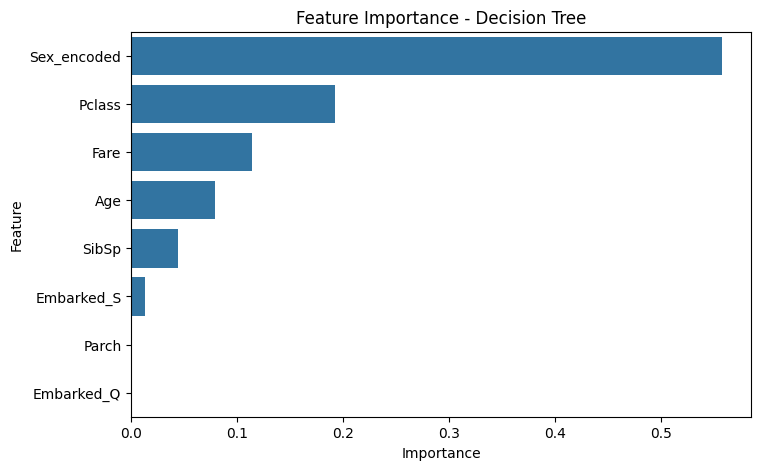

In [12]:
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance - Decision Tree")
plt.show()


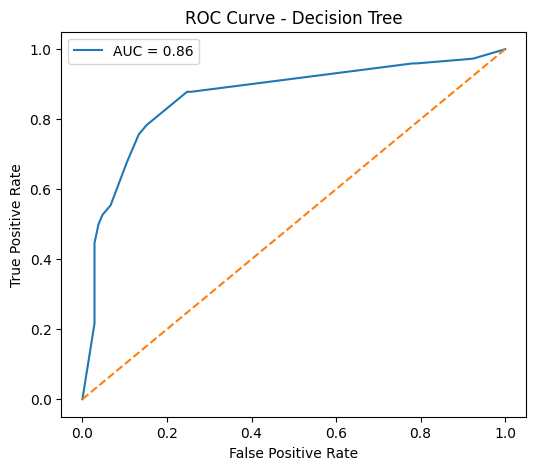

In [13]:


y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()


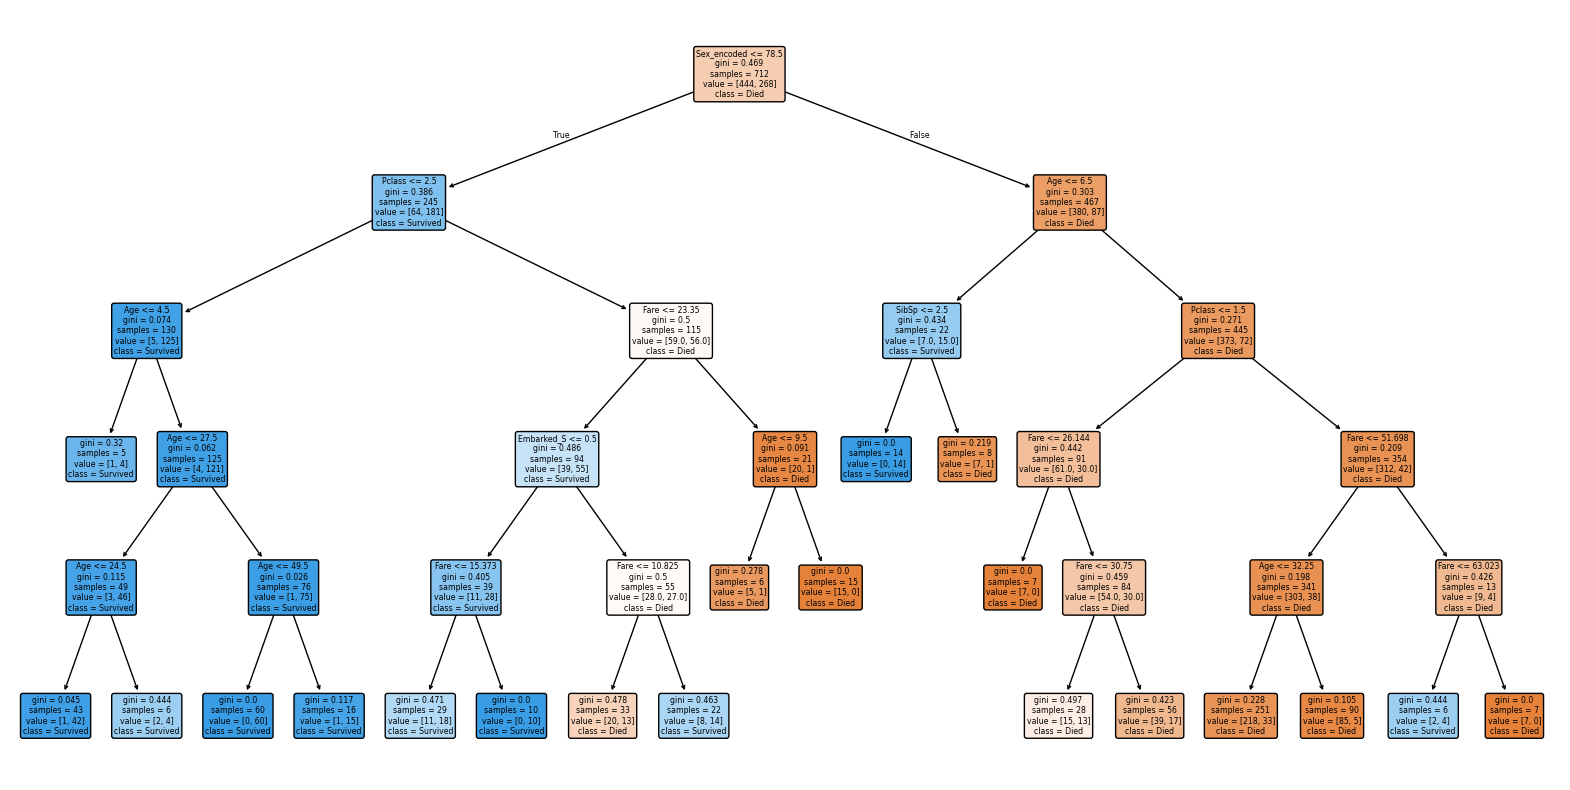

In [14]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=["Died", "Survived"],
    filled=True,
    rounded=True
)
plt.show()
